## Análisis de sentimientos y palabras sobre opiniones de empleados
En el siguiente script se desarrolla el código y se presenta en base a una serie de opiniones variadas generadas mediante una IA. Este experimento carece de validez absoluta por la idiosincrasia del origen de los datos, lo cual no quita que este experimento carezca de validez una vez se cuente con información de empleados reales. 


In [1]:
# Librerías

import numpy as np
import pandas as pd 
import torch
import spacy
from collections import Counter
from datasets import load_dataset
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk

from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import random 
import warnings
warnings.filterwarnings("ignore")

# Librerías para LDA

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim 
import os
import re




c:\Users\artvelasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Modelos

from bertopic import BERTopic
from sklearn.preprocessing import LabelEncoder
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import BertForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments
from sklearn.preprocessing import LabelEncoder

analyzero = SentimentIntensityAnalyzer()
le = LabelEncoder()
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-es-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-es-en")

#### Word Analysis

In [3]:
random.seed(33) # Establecemos la semilla para nuestros modelos 

df = pd.read_excel("C:/Users/artvelasco/Desktop/repo/opinion.xlsx")
df = df[["ID","Departamento", "Opinión"]]
df["Opinión_es"] = df["Opinión"]
df.drop('Opinión', axis=1, inplace=True)
df_list = df.values.tolist()
df.head()

c:\Users\artvelasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\artvelasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


,ID,Departamento,Opinión_es
0,1,Producción,Estoy satisfecho con las oportunidades de crec...
1,2,Calidad,El equipo de trabajo es excelente y las instal...
2,3,Mantenimiento,Estoy contento con mi trabajo y el equipo con ...
3,4,Logística,El ambiente laboral es agradable y las instala...
4,5,Administración,Las oportunidades de capacitación continua son...


Una vez hemos hecho la carga de nuestros datos debemos traducirlos al inglés para poder trabajar con los modelos. Para la traducción nos valdremos de el tokenizador y transformador de Helsinki NLP

In [4]:
input_ids = tokenizer(df['Opinión_es'].tolist(), return_tensors="pt", padding=True, truncation=True).input_ids # Tokenización
outputs = model.generate(input_ids=input_ids, num_beams=5, num_return_sequences=1) # El modelo codifica los tokens
print("Generated:", tokenizer.batch_decode(outputs, skip_special_tokens=True)) 
generated_opinions = tokenizer.batch_decode(outputs, skip_special_tokens=True) # Decodificamos los tokens con la traducción

df['Opinión'] = generated_opinions
print(df)

Generated: ['I am satisfied with the professional growth opportunities offered by the company. I have been able to develop my skills and knowledge in different areas.', 'The work team is excellent and the facilities are adequate. However, in some projects we have had a lack of resources, which has made it difficult to meet the deadlines set.', 'I am happy with my work and the team with which I collaborate. However, I believe that communication between departments should be improved to avoid misunderstandings.', 'The working environment is pleasant and the facilities are adequate. However, I believe that internal communication should be improved to avoid misunderstandings.', 'Continuous training opportunities are a great advantage. I have learned a lot since I started working here. However, I think leadership could be more accessible and listen to our proposals more.', 'The company has a strong commitment to the environment, which is very positive. In addition, the benefits they offer a

In [5]:
# Limpiamos el texto
# Creamos una función que lo haga por nosotros (jejeje)

def clean_text(text):
    # Eliminar URLs
    text_no_urls = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Eliminar caracteres no alfabéticos
    text_alpha = re.sub('[^a-zA-Z]', ' ', text_no_urls)
    # Pasar a minúsculas y eliminar espacios adicionales
    return ' '.join(text_alpha.lower().split())

df['texto_limpio'] = df['Opinión'].apply(clean_text) # App. de función

# Tokenizar el texto limpio (nos servirá en el futuro)
tokens = [t.split() for t in df['texto_limpio']]

# Eliminar stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

df['sin_stopwords'] = df['texto_limpio'].apply(remove_stopwords)
df.head(2)

,ID,Departamento,Opinión_es,Opinión,texto_limpio,sin_stopwords
0,1,Producción,Estoy satisfecho con las oportunidades de crec...,I am satisfied with the professional growth op...,i am satisfied with the professional growth op...,satisfied professional growth opportunities of...
1,2,Calidad,El equipo de trabajo es excelente y las instal...,The work team is excellent and the facilities ...,the work team is excellent and the facilities ...,work team excellent facilities adequate projec...


In [6]:
# Función para filtrar palabras de una sola letra
def filter_one_letter_words(text):
    return [word for word in text.split() if len(word) > 1]

# Contar la frecuencia de las palabras en cada documento
word_counts_per_doc = [Counter(filter_one_letter_words(doc)) for doc in df['sin_stopwords']]

# Obtener las 5 palabras más repetidas por documento
top_words_per_doc = [[word for word, _ in doc.most_common(5)] for doc in word_counts_per_doc]

# Crear un DataFrame para mostrar los resultados
top_words_df = pd.DataFrame({'Top 5 palabras': top_words_per_doc})
top_words_df.index.name = 'Documento'

# Mostrar el DataFrame resultante
print(top_words_df) 

                                              Top 5 palabras
Documento                                                   
0          [satisfied, professional, growth, opportunitie...
1              [work, team, excellent, facilities, adequate]
2                  [happy, work, team, collaborate, believe]
3          [working, environment, pleasant, facilities, a...
4          [continuous, training, opportunities, great, a...
...                                                      ...
275        [development, projects, progressing, planned, ...
276              [clear, vision, defined, objectives, guide]
277           [operations, efficient, constantly, optimized]
278                [clear, vision, defined, objectives, met]
279                                  [leave, floor, viscera]

[280 rows x 1 columns]


### Lematización y extracción de tópicos

In [7]:
#Mostrar la barra de proceso con esta librería
from tqdm import tqdm
tqdm.pandas()

In [8]:
nlp = spacy.load("en_core_web_lg") # Cargamos de la librería SPACY el modelo 

df['lemmas'] = df['sin_stopwords'].progress_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True) and (len(token) > 2)])
df.head(2)

100%|██████████| 280/280 [00:01<00:00, 209.31it/s]


,ID,Departamento,Opinión_es,Opinión,texto_limpio,sin_stopwords,lemmas
0,1,Producción,Estoy satisfecho con las oportunidades de crec...,I am satisfied with the professional growth op...,i am satisfied with the professional growth op...,satisfied professional growth opportunities of...,"[satisfied, professional, growth, opportunity,..."
1,2,Calidad,El equipo de trabajo es excelente y las instal...,The work team is excellent and the facilities ...,the work team is excellent and the facilities ...,work team excellent facilities adequate projec...,"[work, team, excellent, facility, adequate, pr..."


In [9]:
df.to_csv('df_lemmas.csv', index=False)
df = pd.read_csv('df_lemmas.csv')

# Como se guarda se necesita pasar la columna de texto a lista de palabras df['lemmas'] = df['lemmas'].apply(lambda x: eval(x))
df['lemmas'] = df['lemmas'].apply(lambda x: eval(x))

In [10]:
#Diccionario de todas las palabras

id2word = corpora.Dictionary(df['lemmas'])
corpus = [id2word.doc2bow(text) for text in df['lemmas']] # Creamos el corpus con las IDs de las palabras en formato BoW

In [11]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1)],
 [(12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1)],
 [(22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1)],
 [(12, 1),
  (16, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (27, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1)],
 [(8, 1),
  (23, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1)],
 [(2, 1),
  (7, 1),
  (32, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1)],
 [(0, 1),
  (2, 1),
  (5, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (46, 1),
  (51, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1)],
 [(0, 1),
  (2, 1),
  (3, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (10, 1),
  (11, 

In [12]:
#Obtener el número óptimo de topics 

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=90,
                                                        passes=20,
                                                        per_word_topics=True,
                                                        workers=12,
                                                        random_state= 33)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
%%time
# Apply our function
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['lemmas'], 
                                                        start=2, 
                                                        limit=20, 
                                                        step=2)
                                                     

CPU times: total: 20.4 s
Wall time: 1min 33s


In [14]:
model_list

In [15]:
coherence_values

[0.31227786425383075,
 0.3866267999637448,
 0.3805918206954623,
 0.408000729507942,
 0.39946962204892006,
 0.3741928656713465,
 0.3986954012206453,
 0.4025157198835702,
 0.4083735652099882]

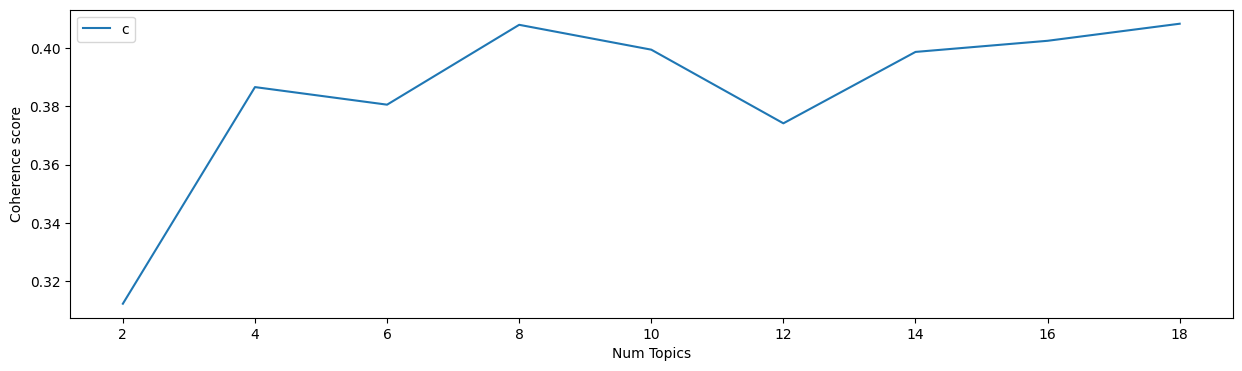

In [16]:
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.figure(figsize=(15, 4))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " consists of a Coherence Value of", round(cv, 4))

Num Topics = 2  consists of a Coherence Value of 0.3123
Num Topics = 4  consists of a Coherence Value of 0.3866
Num Topics = 6  consists of a Coherence Value of 0.3806
Num Topics = 8  consists of a Coherence Value of 0.408
Num Topics = 10  consists of a Coherence Value of 0.3995
Num Topics = 12  consists of a Coherence Value of 0.3742
Num Topics = 14  consists of a Coherence Value of 0.3987
Num Topics = 16  consists of a Coherence Value of 0.4025
Num Topics = 18  consists of a Coherence Value of 0.4084


In [18]:
#%%time
lda_k6= gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        random_state=42,
                                                        num_topics=8, 
                                                        chunksize=90,
                                                        passes=20,
                                                        per_word_topics=True,
                                                        workers=12
                                                        )


lda_k6.save('topicos5.model')

In [19]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_k6.print_topics()]
topics = [' '.join(t[0:7]) for t in words]
topics

['company plan good benefit program improve health',
 'work improve communication lack resource department project',
 'offer company opportunity professional supplier management development',
 'improve management company communication chief employee leadership',
 'lack employee workload training work good flexibility',
 'work company well flexibility collaborative team environment',
 'lack company organization work need boss employee',
 'improve environment internal company work efficiency teleworking']

In [20]:
# Vamos a ver cómo de separados estan nuestros temas entre si
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_k6, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.129370  0.111674       1        1  18.154951
3      0.011199 -0.032589       2        1  14.999841
1     -0.194034 -0.022400       3        1  13.073263
2      0.148215  0.175158       4        1  11.919237
4      0.102948 -0.062443       5        1  11.351978
0      0.037609 -0.099662       6        1  11.343719
5     -0.021994  0.031897       7        1   9.654766
6      0.045427 -0.101634       8        1   9.502244, topic_info=            Term       Freq      Total Category  logprob  loglift
17          lack  27.000000  27.000000  Default  30.0000  30.0000
7          offer  27.000000  27.000000  Default  29.0000  29.0000
30       improve  51.000000  51.000000  Default  28.0000  28.0000
23          work  57.000000  57.000000  Default  27.0000  27.0000
32   environment  24.000000  24.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
114         wage   2.464188  13.522176   Topic8  -4.3966   0.6512
133      problem   2.463540  14.483434   Topic8  -4.3968   0.5822
261        clear   2.007351   9.697768   Topic8  -4.6016   0.7786
130         room   1.676236   5.651911   Topic8  -4.7819   1.1382
151         idea   1.675603   8.039536   Topic8  -4.7823   0.7854

[459 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         4  0.896782         able
341       2  0.617907  absenteeism
136       2  0.314417   acceptable
136       7  0.628834   acceptable
35        2  0.466830   accessible
...     ...       ...          ...
23        7  0.258656         work
23        8  0.086219         work
80        4  0.210900     workload
80        5  0.738150     workload
243       5  0.840405        wrong

[637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 2, 3, 5, 1, 6, 7])

In [21]:
#Importancia de cada tópico
def document_to_lda_features(lda_k5,document):
  topic_importance=np.array(lda_k5.get_document_topics(document, minimum_probability=0))
  return topic_importance[:,1]

#Buscar el topico predominante en cada documento
df['lda_features']=list(map(lambda doc: document_to_lda_features(lda_k6,doc), corpus))

In [22]:
def topic_important(item_score):
    score=np.argmax(item_score, axis=0)
    return score

# Apply tokenizer
df['topic_dominant'] = df['lda_features'].apply(topic_important)
df.head(2)

,ID,Departamento,Opinión_es,Opinión,texto_limpio,sin_stopwords,lemmas,lda_features,topic_dominant
0,1,Producción,Estoy satisfecho con las oportunidades de crec...,I am satisfied with the professional growth op...,i am satisfied with the professional growth op...,satisfied professional growth opportunities of...,"[satisfied, professional, growth, opportunity,...","[0.009618407115340233, 0.317455530166626, 0.45...",2
1,2,Calidad,El equipo de trabajo es excelente y las instal...,The work team is excellent and the facilities ...,the work team is excellent and the facilities ...,work team excellent facilities adequate projec...,"[work, team, excellent, facility, adequate, pr...","[0.00961869303137064, 0.9326648712158203, 0.00...",1


In [23]:
# Número de documentos asociados a cada tópico
df["topic_dominant"].value_counts()

topic_dominant
7    47
3    42
2    41
1    35
4    35
6    28
0    27
5    25
Name: count, dtype: int64

In [24]:
#plt.figure(figsize=(20, 6))
#ax=df["topic_dominant"].value_counts().sort_index().plot(kind='bar', color ='orange')
#plt.ylabel('Frecuencia Absoluta')
# plt.xlabel('Tópicos')
# plt.title('Distribución de tópicos en el corpus')
# totals = df["topic_dominant"].value_counts().sort_index()
# for i, total in enumerate(totals):
#     ax.text(i, total + 0.5, str(total), ha='center', va='bottom')
# topics= {
#     0: 'company good program plan health benefit improve',
#     1: 'company offer improve benefit environment commitment good',
#     2: 'team work facility environment invest technology collaborative',
#     3: 'knowledge offer competent professional skill develop able',
#     4: 'work training collaborative continuous team well help',
#     5: 'work misunderstanding communication internal improve environment avoid',
#     6: 'effort workload recognize reasonable opportunity company work',
#     7: 'opportunity professional company offer development good growth'

# }
# ax.set_xticklabels([topics[i] for i in range(len(topics))], rotation=20)
# plt.show()

#### WordCloud

In [25]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(10, 7))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [26]:
# Generate word cloud
text = ' '.join([' '.join(lemmas) for lemmas in df['lemmas']])
wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='Set2', collocations=False).generate(text)

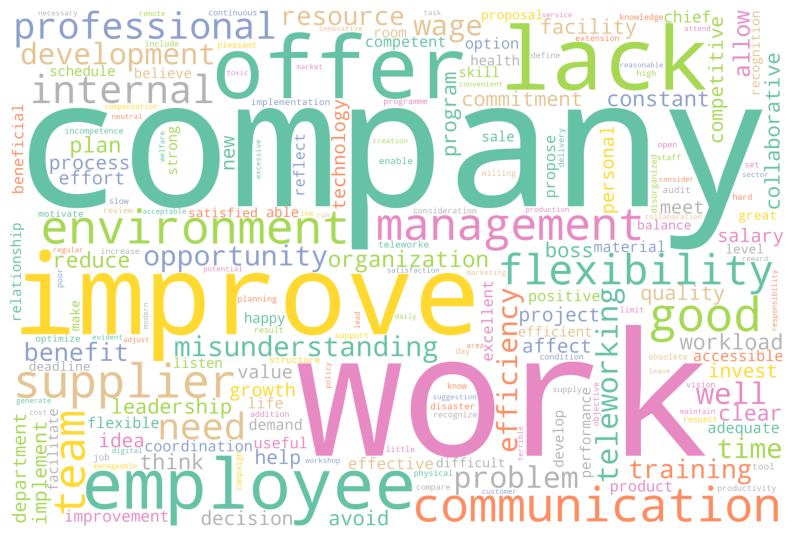

In [27]:
plot_cloud(wordcloud) 

In [28]:
# from PIL import Image
# maska = np.array(Image.open("C:/Users/artvelasco/Desktop/repo/GEST.MC-9cd38543.png"))

In [29]:
# # A similar function, but using the mask
# def generate_better_wordcloud(texto, title, mask=None):
#     cloud = WordCloud(scale=3,
#                       max_words=150,
#                       colormap='RdYlGn',
#                       mask=mask,
#                       background_color='white',
#                       collocations=True).generate(texto)
#     plt.figure(figsize=(10,8))
#     plt.imshow(cloud)
#     plt.axis('off')
#     plt.title(title)
#     plt.show()
    
# # Use the function with the rome_corpus and our mask to create word cloud     
# generate_better_wordcloud(text, 'Rome, Italy', mask=maska)

In [30]:
# wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='Set2', mask = maska).generate(text)
# plt.axis('off')
# plt.imshow(wordcloud)

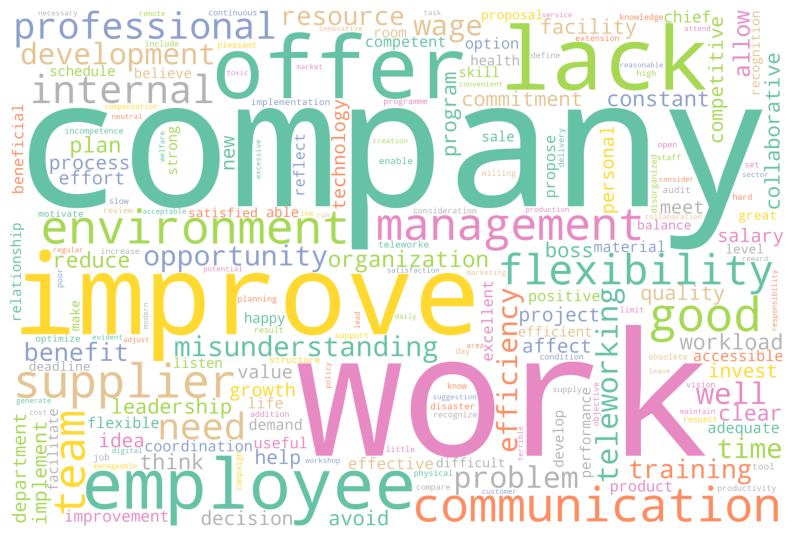

In [31]:
plot_cloud(wordcloud)

In [32]:
# wordcloud = WordCloud(background_color = 'black', mask = maska, contour_width = 2,
#      contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 500).generate(text)
# # create image as cloud
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# # store to file
# plt.savefig("cloud.png", format="png")
# plt.show()

#### Sentiment Analysis avec RoBERTa

In [33]:
# Crear el pipeline de clasificación
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions")

In [34]:
df

,ID,Departamento,Opinión_es,Opinión,texto_limpio,sin_stopwords,lemmas,lda_features,topic_dominant
0,1,Producción,Estoy satisfecho con las oportunidades de crec...,I am satisfied with the professional growth op...,i am satisfied with the professional growth op...,satisfied professional growth opportunities of...,"[satisfied, professional, growth, opportunity,...","[0.009618407115340233, 0.317455530166626, 0.45...",2
1,2,Calidad,El equipo de trabajo es excelente y las instal...,The work team is excellent and the facilities ...,the work team is excellent and the facilities ...,work team excellent facilities adequate projec...,"[work, team, excellent, facility, adequate, pr...","[0.00961869303137064, 0.9326648712158203, 0.00...",1
2,3,Mantenimiento,Estoy contento con mi trabajo y el equipo con ...,I am happy with my work and the team with whic...,i am happy with my work and the team with whic...,happy work team collaborate believe communicat...,"[happy, work, team, collaborate, believe, comm...","[0.011366978287696838, 0.9204133749008179, 0.0...",1
3,4,Logística,El ambiente laboral es agradable y las instala...,The working environment is pleasant and the fa...,the working environment is pleasant and the fa...,working environment pleasant facilities adequa...,"[work, environment, pleasant, facility, adequa...","[0.010418698191642761, 0.927040159702301, 0.01...",1
4,5,Administración,Las oportunidades de capacitación continua son...,Continuous training opportunities are a great ...,continuous training opportunities are a great ...,continuous training opportunities great advant...,"[continuous, training, opportunity, great, adv...","[0.008336856961250305, 0.008336944505572319, 0...",3
...,...,...,...,...,...,...,...,...,...
275,276,Desarrollo,Los proyectos de desarrollo avanzan según lo p...,Development projects are progressing as planne...,development projects are progressing as planne...,development projects progressing planned good ...,"[development, project, progress, plan, good, r...","[0.316947340965271, 0.5758053064346313, 0.0178...",1
276,277,Estrategia,Hay una visión clara y objetivos definidos que...,There is a clear vision and defined objectives...,there is a clear vision and defined objectives...,clear vision defined objectives guide daily work,"[clear, vision, define, objective, guide, dail...","[0.015628935769200325, 0.01564057543873787, 0....",3
277,278,Operaciones,Las operaciones son eficientes y se optimizan ...,Operations are efficient and constantly optimi...,operations are efficient and constantly optimized,operations efficient constantly optimized,"[operation, efficient, constantly, optimize]","[0.02500515803694725, 0.025010205805301666, 0....",5
278,279,Compras,No hay una visión clara y los objetivos defini...,There is no clear vision and the defined objec...,there is no clear vision and the defined objec...,clear vision defined objectives met,"[clear, vision, define, objective, meet]","[0.020833812654018402, 0.020914651453495026, 0...",3


In [35]:
df2 = df[['ID', 'Departamento', 'Opinión_es', 'Opinión', 'texto_limpio', 'sin_stopwords', 'lemmas']]
df2.head()

,ID,Departamento,Opinión_es,Opinión,texto_limpio,sin_stopwords,lemmas
0,1,Producción,Estoy satisfecho con las oportunidades de crec...,I am satisfied with the professional growth op...,i am satisfied with the professional growth op...,satisfied professional growth opportunities of...,"[satisfied, professional, growth, opportunity,..."
1,2,Calidad,El equipo de trabajo es excelente y las instal...,The work team is excellent and the facilities ...,the work team is excellent and the facilities ...,work team excellent facilities adequate projec...,"[work, team, excellent, facility, adequate, pr..."
2,3,Mantenimiento,Estoy contento con mi trabajo y el equipo con ...,I am happy with my work and the team with whic...,i am happy with my work and the team with whic...,happy work team collaborate believe communicat...,"[happy, work, team, collaborate, believe, comm..."
3,4,Logística,El ambiente laboral es agradable y las instala...,The working environment is pleasant and the fa...,the working environment is pleasant and the fa...,working environment pleasant facilities adequa...,"[work, environment, pleasant, facility, adequa..."
4,5,Administración,Las oportunidades de capacitación continua son...,Continuous training opportunities are a great ...,continuous training opportunities are a great ...,continuous training opportunities great advant...,"[continuous, training, opportunity, great, adv..."


In [36]:
def get_emotion(text):
    return(classifier(text)[0]['label'])

df2['Opinión'][:10].apply(get_emotion)

0          approval
1    disappointment
2               joy
3          approval
4        admiration
5        admiration
6          approval
7          optimism
8    disappointment
9        admiration
Name: Opinión, dtype: object

In [37]:
df2['RoBertaEmotions'] = df2['Opinión'].apply(get_emotion)

df2["RoBertaEmotions"].value_counts()

RoBertaEmotions
neutral           68
approval          65
disappointment    58
admiration        32
disapproval       17
annoyance         13
optimism           8
joy                7
desire             5
confusion          2
realization        1
gratitude          1
fear               1
nervousness        1
caring             1
Name: count, dtype: int64

In [38]:
# Create a countplot using Plotly Express histogram
fig = px.histogram(df2, x='RoBertaEmotions', color='RoBertaEmotions', title='RoBertaEmotions')
fig.update_layout(barmode='stack')  # Set barmode to 'count' for countplot effect
fig.update_xaxes(categoryorder='total descending')
fig.show()

In [39]:
df2_2 = df2[["ID", 'Departamento', 'Opinión_es', 'Opinión', 'sin_stopwords', 'lemmas',"RoBertaEmotions"]] 

In [40]:
df2_2

,ID,Departamento,Opinión_es,Opinión,sin_stopwords,lemmas,RoBertaEmotions
0,1,Producción,Estoy satisfecho con las oportunidades de crec...,I am satisfied with the professional growth op...,satisfied professional growth opportunities of...,"[satisfied, professional, growth, opportunity,...",approval
1,2,Calidad,El equipo de trabajo es excelente y las instal...,The work team is excellent and the facilities ...,work team excellent facilities adequate projec...,"[work, team, excellent, facility, adequate, pr...",disappointment
2,3,Mantenimiento,Estoy contento con mi trabajo y el equipo con ...,I am happy with my work and the team with whic...,happy work team collaborate believe communicat...,"[happy, work, team, collaborate, believe, comm...",joy
3,4,Logística,El ambiente laboral es agradable y las instala...,The working environment is pleasant and the fa...,working environment pleasant facilities adequa...,"[work, environment, pleasant, facility, adequa...",approval
4,5,Administración,Las oportunidades de capacitación continua son...,Continuous training opportunities are a great ...,continuous training opportunities great advant...,"[continuous, training, opportunity, great, adv...",admiration
...,...,...,...,...,...,...,...
275,276,Desarrollo,Los proyectos de desarrollo avanzan según lo p...,Development projects are progressing as planne...,development projects progressing planned good ...,"[development, project, progress, plan, good, r...",approval
276,277,Estrategia,Hay una visión clara y objetivos definidos que...,There is a clear vision and defined objectives...,clear vision defined objectives guide daily work,"[clear, vision, define, objective, guide, dail...",neutral
277,278,Operaciones,Las operaciones son eficientes y se optimizan ...,Operations are efficient and constantly optimi...,operations efficient constantly optimized,"[operation, efficient, constantly, optimize]",neutral
278,279,Compras,No hay una visión clara y los objetivos defini...,There is no clear vision and the defined objec...,clear vision defined objectives met,"[clear, vision, define, objective, meet]",neutral


#### Extracción de Tópicos con Transformers

In [79]:
topic_model = BERTopic()
from umap import UMAP

umap_model = UMAP(random_state=33)

topic_model = BERTopic(umap_model=umap_model)
topics, probs = topic_model.fit_transform(df2["sin_stopwords"])

In [80]:
Representation = topic_model.get_topic_info()[["Topic", "Representation"]]
Representation

,Topic,Representation
0,-1,"[projects, health, plan, management, good, pro..."
1,0,"[flexibility, teleworking, work, company, comm..."
2,1,"[communication, internal, team, misunderstandi..."
3,2,"[suppliers, materials, problems, supplier, rel..."
4,3,"[wages, reflect, competitive, motivate, salary..."
5,4,"[opportunities, professional, development, gro..."
6,5,"[organization, lack, structure, company, poten..."
7,6,"[workload, effort, recognition, valued, recogn..."


In [78]:
topic_model.get_params()

{'calculate_probabilities': False,
 'ctfidf_model': ClassTfidfTransformer(),
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x2414f057b60>,
 'hdbscan_model': HDBSCAN(min_cluster_size=10, prediction_data=True),
 'language': 'english',
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': None,
 'representation_model': None,
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': UMAP(n_jobs=1, random_state=33, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 'vectorizer_model': CountVectorizer(),
 'verbose': False,
 'zeroshot_min_similarity': 0.7,
 'zeroshot_topic_list': None}

In [81]:
df3 = topic_model.get_document_info(df2["sin_stopwords"])
df3 = df3[["Document", "Topic", "Representation", "Top_n_words", "Representative_document"]]

In [82]:
tokenizer2 = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
model2 = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-es")

In [83]:
input_ids = tokenizer2(df3['Top_n_words'].tolist(), return_tensors="pt", padding=True, truncation=True).input_ids # Tokenización
outputs = model2.generate(input_ids=input_ids, num_beams=5, num_return_sequences=1) # El modelo codifica los tokens
print("Generated:", tokenizer2.batch_decode(outputs, skip_special_tokens=True)) 
generated_ = tokenizer2.batch_decode(outputs, skip_special_tokens=True) # Decodificamos los tokens con la traducción

df3['Topic_es'] = generated_

Generated: ['oportunidades - profesional - desarrollo - crecimiento - capacidad - ofertas - oferta - habilidades - empresa - satisfecho', 'organización - falta - estructura - empresa - potencial - constante - claro - obstáculo - intenciones - deseado', 'comunicación - interna - equipo - malentendidos - medio ambiente - trabajo - mejora - evitar - mejorar - colaboración', 'comunicación - interna - equipo - malentendidos - medio ambiente - trabajo - mejora - evitar - mejorar - colaboración', 'comunicación - interna - equipo - malentendidos - medio ambiente - trabajo - mejora - evitar - mejorar - colaboración', 'flexibilidad - teletrabajo - trabajo - empresa - compromiso - tiempo - vida - personal - empleados', 'oportunidades - profesional - desarrollo - crecimiento - capacidad - ofertas - oferta - habilidades - empresa - satisfecho', 'oportunidades - profesional - desarrollo - crecimiento - capacidad - ofertas - oferta - habilidades - empresa - satisfecho', 'proyectos - salud - plan - ge

In [84]:
# Create a countplot using Plotly Express histogram
fig = px.histogram(df3, x='Topic', color='Topic_es', labels={"Topic_es": "Temas"} , title='Distribución de temas')
fig.update_layout(barmode='stack')  # Set barmode to 'count' for countplot effect
fig.update_xaxes(categoryorder='total descending')
fig.show()

In [85]:
topic_model.visualize_topics()

In [86]:
# topic_model.reduce_topics(df2["sin_stopwords"], nr_topics=8)
df_topics = topic_model.get_document_info(df2["sin_stopwords"])
df_topics = df_topics[["Document", "Topic", "Representation", "Top_n_words", "Representative_document"]]
df_topics

,Document,Topic,Representation,Top_n_words,Representative_document
0,satisfied professional growth opportunities of...,4,"[opportunities, professional, development, gro...",opportunities - professional - development - g...,False
1,work team excellent facilities adequate projec...,5,"[organization, lack, structure, company, poten...",organization - lack - structure - company - po...,False
2,happy work team collaborate believe communicat...,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False
3,working environment pleasant facilities adequa...,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False
4,continuous training opportunities great advant...,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False
...,...,...,...,...,...
275,development projects progressing planned good ...,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False
276,clear vision defined objectives guide daily work,5,"[organization, lack, structure, company, poten...",organization - lack - structure - company - po...,False
277,operations efficient constantly optimized,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False
278,clear vision defined objectives met,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False


In [50]:
topic_model.visualize_term_rank()

In [51]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9,-1_demand_propose_return_giving,"[demand, propose, return, giving, toxic, creat...",[propose creation rest space recreational acti...
1,0,129,0_suppliers_wages_lack_workload,"[suppliers, wages, lack, workload, company, wo...",[work team amazing facilities notch projects l...
2,1,61,1_communication_internal_environment_team,"[communication, internal, environment, team, m...",[pleased working environment company team coll...
3,2,28,2_opportunities_professional_development_growth,"[opportunities, professional, development, gro...",[company offers excellent opportunities profes...
4,3,22,3_flexibility_work_life_personal,"[flexibility, work, life, personal, balance, c...",[company offers training lack time flexibility...
5,4,20,4_teleworking_allowed_improving_better,"[teleworking, allowed, improving, better, enab...",[maintenance requires physical presence telewo...
6,5,11,5_commitment_strong_company_addition,"[commitment, strong, company, addition, invest...",[company strong commitment quality products ad...


In [87]:
df_topics.rename(columns={"Document":"sin_stopwords"}, inplace= True)

In [88]:
resultao = pd.merge(df2_2, df_topics, on="sin_stopwords")

In [89]:
# Función para obtener el puntaje 'compound'
def get_compound_score(text):
    return analyzero.polarity_scores(text)['compound']
resultao['compound'] = resultao['Opinión'].apply(get_compound_score)

In [90]:
resultao

,ID,Departamento,Opinión_es,Opinión,sin_stopwords,lemmas,RoBertaEmotions,Topic,Representation,Top_n_words,Representative_document,compound
0,1,Producción,Estoy satisfecho con las oportunidades de crec...,I am satisfied with the professional growth op...,satisfied professional growth opportunities of...,"[satisfied, professional, growth, opportunity,...",approval,4,"[opportunities, professional, development, gro...",opportunities - professional - development - g...,False,0.7906
1,2,Calidad,El equipo de trabajo es excelente y las instal...,The work team is excellent and the facilities ...,work team excellent facilities adequate projec...,"[work, team, excellent, facility, adequate, pr...",disappointment,5,"[organization, lack, structure, company, poten...",organization - lack - structure - company - po...,False,0.2023
2,3,Mantenimiento,Estoy contento con mi trabajo y el equipo con ...,I am happy with my work and the team with whic...,happy work team collaborate believe communicat...,"[happy, work, team, collaborate, believe, comm...",joy,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False,0.6808
3,4,Logística,El ambiente laboral es agradable y las instala...,The working environment is pleasant and the fa...,working environment pleasant facilities adequa...,"[work, environment, pleasant, facility, adequa...",approval,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False,0.7269
4,5,Administración,Las oportunidades de capacitación continua son...,Continuous training opportunities are a great ...,continuous training opportunities great advant...,"[continuous, training, opportunity, great, adv...",admiration,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False,0.8271
...,...,...,...,...,...,...,...,...,...,...,...,...
279,276,Desarrollo,Los proyectos de desarrollo avanzan según lo p...,Development projects are progressing as planne...,development projects progressing planned good ...,"[development, project, progress, plan, good, r...",approval,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False,0.4404
280,277,Estrategia,Hay una visión clara y objetivos definidos que...,There is a clear vision and defined objectives...,clear vision defined objectives guide daily work,"[clear, vision, define, objective, guide, dail...",neutral,5,"[organization, lack, structure, company, poten...",organization - lack - structure - company - po...,False,0.5574
281,278,Operaciones,Las operaciones son eficientes y se optimizan ...,Operations are efficient and constantly optimi...,operations efficient constantly optimized,"[operation, efficient, constantly, optimize]",neutral,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False,0.7003
282,279,Compras,No hay una visión clara y los objetivos defini...,There is no clear vision and the defined objec...,clear vision defined objectives met,"[clear, vision, define, objective, meet]",neutral,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False,-0.4449


In [ ]:
resultao.to_excel("BERT_app2.xlsx",
             sheet_name='Merge') 

c:\Users\artvelasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

c:\Users\artvelasco\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\writer\excel.py:292: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [92]:
resultao

,ID,Departamento,Opinión_es,Opinión,sin_stopwords,lemmas,RoBertaEmotions,Topic,Representation,Top_n_words,Representative_document,compound
0,1,Producción,Estoy satisfecho con las oportunidades de crec...,I am satisfied with the professional growth op...,satisfied professional growth opportunities of...,"[satisfied, professional, growth, opportunity,...",approval,4,"[opportunities, professional, development, gro...",opportunities - professional - development - g...,False,0.7906
1,2,Calidad,El equipo de trabajo es excelente y las instal...,The work team is excellent and the facilities ...,work team excellent facilities adequate projec...,"[work, team, excellent, facility, adequate, pr...",disappointment,5,"[organization, lack, structure, company, poten...",organization - lack - structure - company - po...,False,0.2023
2,3,Mantenimiento,Estoy contento con mi trabajo y el equipo con ...,I am happy with my work and the team with whic...,happy work team collaborate believe communicat...,"[happy, work, team, collaborate, believe, comm...",joy,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False,0.6808
3,4,Logística,El ambiente laboral es agradable y las instala...,The working environment is pleasant and the fa...,working environment pleasant facilities adequa...,"[work, environment, pleasant, facility, adequa...",approval,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False,0.7269
4,5,Administración,Las oportunidades de capacitación continua son...,Continuous training opportunities are a great ...,continuous training opportunities great advant...,"[continuous, training, opportunity, great, adv...",admiration,1,"[communication, internal, team, misunderstandi...",communication - internal - team - misunderstan...,False,0.8271
...,...,...,...,...,...,...,...,...,...,...,...,...
279,276,Desarrollo,Los proyectos de desarrollo avanzan según lo p...,Development projects are progressing as planne...,development projects progressing planned good ...,"[development, project, progress, plan, good, r...",approval,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False,0.4404
280,277,Estrategia,Hay una visión clara y objetivos definidos que...,There is a clear vision and defined objectives...,clear vision defined objectives guide daily work,"[clear, vision, define, objective, guide, dail...",neutral,5,"[organization, lack, structure, company, poten...",organization - lack - structure - company - po...,False,0.5574
281,278,Operaciones,Las operaciones son eficientes y se optimizan ...,Operations are efficient and constantly optimi...,operations efficient constantly optimized,"[operation, efficient, constantly, optimize]",neutral,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False,0.7003
282,279,Compras,No hay una visión clara y los objetivos defini...,There is no clear vision and the defined objec...,clear vision defined objectives met,"[clear, vision, define, objective, meet]",neutral,-1,"[projects, health, plan, management, good, pro...",projects - health - plan - management - good -...,False,-0.4449


In [94]:
#cod_emo = le.fit_transform(resultao['RoBertaEmotions'])
cod_dpto = le.fit_transform(resultao['Departamento'])

# To add it to original dataframe, we need to convert it to data frame 

#cod_emo_df = pd.DataFrame(cod_emo, columns=["emo_coded"])
cod_dpto_df = pd.DataFrame(cod_dpto, columns=["cod_dpto"])
data_encoded = pd.concat([resultao, cod_dpto_df], axis=1)
data_encoded.drop(['ID', 'Departamento', 'Opinión_es', 'sin_stopwords', 'Opinión', 'lemmas', 'Representation', 'Top_n_words', 'Representative_document'], axis = 1, inplace= True)
data_encoded

,RoBertaEmotions,Topic,compound,cod_dpto
0,approval,4,0.7906,25
1,disappointment,5,0.2023,4
2,joy,1,0.6808,19
3,approval,1,0.7269,18
4,admiration,1,0.8271,0
...,...,...,...,...
279,approval,-1,0.4404,8
280,neutral,5,0.5574,9
281,neutral,-1,0.7003,22
282,neutral,-1,-0.4449,5


In [59]:
#topics, probs = topic_model.fit_transform(df2["Opinión_es"])

In [60]:
#Representation = topic_model.get_topic_info()[["Topic", "Representation"]]
#Representation

In [61]:
# !pip install -q evaluate seqeval

In [62]:
# import evaluate

# seqeval = evaluate.load("seqeval")

### A ver